# This notebook shows the final selections for the GalaxyZoo candidates.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.lines as lines
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM

In [3]:
#---------------------------------------------------------
#Constants, taken from mass_SFR.py done by former students
#---------------------------------------------------------
Mag_sun_w1 = 3.254
Mag_sun_error_w1 = np.sqrt(0.008**2+0.02**2) #extra 0!!
Mag_sun_kt = 3.302
Mag_sun_error_kt = np.sqrt(0.008**2+0.02**2)
lum_sun = 3.828e26 #in W from NASA fact sheet
c = const.c.to('km/s').value #c in km/s
nu_3 = (c*1000)/(11.5608e-6) #in s^-1 from Table 1 in Jarrett et al. (2011) (link: http://iopscience.iop.org/article/10.1088/0004-637X/735/2/112/pdf)
zp_3 = 31.674 #in Jy Table 1 this WISE guide: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
a_3 = [1.13, 10.24] #Cluver14
a_4 = [0.82, 7.3] #Cluver14
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
h0_error = 2.4 # km/(Mpc*s)
parsec = 3.08567758e16 #m
jansky = 1e-26 #W/m^2/Hz
cosmo = FlatLambdaCDM(h0, Om0=0.262) # Shawn: to match cosmology used by Becky

In [4]:
# import mac and zoo
#mac_all = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/mac_with_mass.csv')
zoo_all = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_with_mass.csv')
#import no_lens
#no_lens = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/no_lens.csv')

In [4]:
# load in Sersic photometric data to get effective radii
# Columns GALRE_r and GALRE_i are effective radii in r and i bands
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/SersicCatSDSS.fits')  # open a FITS file
photometry = hdul[1].data  # assume the first extension is a table
#print(hdul[1].columns)

Reff_GAMA_ID = photometry['CATAID']
Reff_i = photometry['GALRE_i']
Reff_r = photometry['GALRE_r']

Reff_data = list(zip(Reff_GAMA_ID, Reff_r, Reff_i))
Reff = pd.DataFrame(Reff_data, columns = ['GAMA_ID',
                                                    'Reff_r',
                                                    'Reff_i'])

Reff
#print(zoo_data.columns)

,GAMA_ID,Reff_r,Reff_i
0,6802,1.107750,1.144532
1,6803,0.535145,0.541552
2,6804,0.795294,0.540705
3,6805,0.448633,0.390189
4,6806,1.690017,1.583740
5,6807,1.402307,1.951759
6,6808,1.461395,1.732426
7,6809,1.426885,0.832550
8,6810,1.460514,1.493871
9,6811,0.772750,0.667525


In [7]:
# There are some whacky Reff's in here. Take those with 
# Reff < 5
Reff_5 = Reff[(Reff_r < 5) & (Reff_i < 5)]
Reff_5

,GAMA_ID,Reff_r,Reff_i
0,6802,1.107750,1.144532
1,6803,0.535145,0.541552
2,6804,0.795294,0.540705
3,6805,0.448633,0.390189
4,6806,1.690017,1.583740
5,6807,1.402307,1.951759
6,6808,1.461395,1.732426
7,6809,1.426885,0.832550
8,6810,1.460514,1.493871
9,6811,0.772750,0.667525


## First cut will include only those candidates with lens score greater than 30%

In [6]:
# cut mac at score of 0.30
zoo_30 = zoo_all[zoo_all.LENS_SCORE >= 0.30]
zoo_30

,Unnamed: 0,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z
319,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550
322,322,511865,216.31907,-1.13127,0.315974,2.066000e+10,0.0845
487,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539
605,605,505441,219.86678,-1.91433,0.300620,1.733000e+11,0.1335
896,896,164479,177.65720,-2.81587,0.356799,1.184000e+10,0.0993
1106,1106,165259,180.44234,-2.82167,0.335770,1.010000e+10,0.1018
1264,1264,70022,178.02218,0.07392,0.368109,8.046000e+10,0.0599
1867,1867,171055,176.81020,-2.29890,0.307655,3.707000e+09,0.1314
2065,2065,170898,176.46563,-2.33643,0.336096,2.319000e+11,0.1215
2401,2401,184275,175.91698,-1.44119,0.317262,4.411000e+10,0.1237


## I have chosen to remove my own visual judgment of lenses in order to have my selection based on physical properties.

In [32]:
# cut out mac candidates in no_lens
#zoo_candidates = zoo_30[~zoo_30.GAMA_ID.isin(no_lens.GAMA_ID)]
#zoo_candidates.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates.csv') 
#len(zoo_candidates)

## The next cut will be based on estimates of Einstein radii for candidates. 
### Assuming Ds = 2DL and dark matter fraction Chabrier IMF (FDM = 0.61), where the stellar mass is 0.39 times the total mass. So the total mass is M*/0.39.
### If the difference between the estimated Einstein radius and the effective radius for the lens candidate is smaller than the KiDS PSF (6.5 arc-seconds) then the resolution makes it impossible for a lens to have been spotted.

## Update 2/18/20: Reff is unreliable. So I will do something similar to what Petrillo did and take only those whose Einstein radii is greater than twice the PSF.

In [7]:
# Estimate total mass, create new column in zoo_30
zoo_30['TOTAL_MASS'] = zoo_30.STELLAR_MASS/0.39
zoo_30

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS
319,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11
322,322,511865,216.31907,-1.13127,0.315974,2.066000e+10,0.0845,5.297436e+10
487,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11
605,605,505441,219.86678,-1.91433,0.300620,1.733000e+11,0.1335,4.443590e+11
896,896,164479,177.65720,-2.81587,0.356799,1.184000e+10,0.0993,3.035897e+10
1106,1106,165259,180.44234,-2.82167,0.335770,1.010000e+10,0.1018,2.589744e+10
1264,1264,70022,178.02218,0.07392,0.368109,8.046000e+10,0.0599,2.063077e+11
1867,1867,171055,176.81020,-2.29890,0.307655,3.707000e+09,0.1314,9.505128e+09
2065,2065,170898,176.46563,-2.33643,0.336096,2.319000e+11,0.1215,5.946154e+11
2401,2401,184275,175.91698,-1.44119,0.317262,4.411000e+10,0.1237,1.131026e+11


In [8]:
# estimate einstein radius
M = zoo_30.TOTAL_MASS
Z = zoo_30.Z
# if Zsource = 2*Zlens... Zsource*Zlens/(Zsource-Zlens) becomes 2*Zlens
# mass term
A = (M/(10**11.09))**(1/2)
# distances term, h0*1000 gives km/Gpc*s
B = ((c/(h0*1000))*(2*Z))**(-1/2)
zoo_30['theta_e'] = A*B #gives arcsecs

zoo_30

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Unnamed: 0,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e
319,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680
322,322,511865,216.31907,-1.13127,0.315974,2.066000e+10,0.0845,5.297436e+10,0.791967
487,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370
605,605,505441,219.86678,-1.91433,0.300620,1.733000e+11,0.1335,4.443590e+11,1.824858
896,896,164479,177.65720,-2.81587,0.356799,1.184000e+10,0.0993,3.035897e+10,0.553059
1106,1106,165259,180.44234,-2.82167,0.335770,1.010000e+10,0.1018,2.589744e+10,0.504496
1264,1264,70022,178.02218,0.07392,0.368109,8.046000e+10,0.0599,2.063077e+11,1.856296
1867,1867,171055,176.81020,-2.29890,0.307655,3.707000e+09,0.1314,9.505128e+09,0.269020
2065,2065,170898,176.46563,-2.33643,0.336096,2.319000e+11,0.1215,5.946154e+11,2.212752
2401,2401,184275,175.91698,-1.44119,0.317262,4.411000e+10,0.1237,1.131026e+11,0.956432


In [12]:
#zoo_30.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_30_021920.csv')

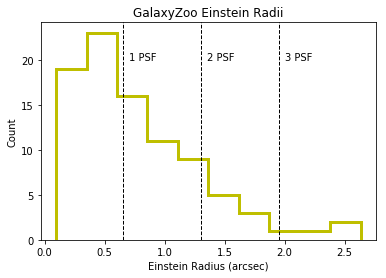

In [9]:
# Histogram of Einstein Radii
plt.xlabel("Einstein Radius (arcsec)")
plt.ylabel("Count")
plt.title("GalaxyZoo Einstein Radii")
plt.hist(zoo_30.theta_e,bins=10,color='y',label='GZ', histtype = 'step', linewidth=3)
#plt.hist(s4tm_shu_17.theta_e_sie,bins=10,color='c',label='S4TM', histtype = 'step', linewidth=3)
#plt.hist(bells_brownstein_12.theta_e_sie,bins=10,color='k',label='BELLS', histtype = 'step', linewidth=3)
#plt.hist(spec_121519.theta_e_chabrier,bins=10,color='b',label='GAMA', histtype = 'step', linewidth=3)
#plt.legend(loc='upper right')
plt.axvline(0.65, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.3, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1.95, color='k', linestyle='dashed', linewidth=1)
plt.text(0.7, 20, '1 PSF')
plt.text(1.35, 20, '2 PSF')
plt.text(2, 20, '3 PSF')
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/gz_theta_e.png')
plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/Final_PDFs_for_Paper/gz_theta_e.pdf')



## Zoo candidates can be cut at twice the PSF.

In [63]:
zoo_candidates_021820 = zoo_30[zoo_30.theta_e > 1.3]
#zoo_candidates_021820.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates_021820.csv')
zoo_candidates_021820

,Unnamed: 0,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e
319,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680
487,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370
605,605,505441,219.86678,-1.91433,0.300620,1.733000e+11,0.1335,4.443590e+11,1.824858
1264,1264,70022,178.02218,0.07392,0.368109,8.046000e+10,0.0599,2.063077e+11,1.856296
2065,2065,170898,176.46563,-2.33643,0.336096,2.319000e+11,0.1215,5.946154e+11,2.212752
4670,4670,55245,181.07958,-0.31553,0.314054,1.274000e+11,0.0936,3.266667e+11,1.868604
5698,5698,185451,180.28326,-1.61006,0.302985,8.222000e+10,0.1079,2.108205e+11,1.398133
7874,7874,106562,216.62566,0.84498,0.363876,8.985000e+10,0.1268,2.303846e+11,1.348249
8137,8137,593852,218.07820,-0.03958,0.386318,2.251000e+11,0.1308,5.771795e+11,2.101137
9359,9359,93803,222.48917,0.55835,0.477719,8.894000e+10,0.0398,2.280513e+11,2.394294


## It appears that my Einstein radius calculation may be an underestimate. With that, we will use theta_e > 0.65 arcsec (1 PSF).

In [14]:
#zoo_1psf = zoo_30[zoo_30.theta_e > 0.65]
#zoo_1psf.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates_022120.csv')

In [55]:
# merge zoo_30 with Reff to add columns of Reff in i and r bands
#zoo_30_Reff = pd.merge(zoo_30, Reff_5, on = 'GAMA_ID', how = 'left')
#zoo_30_Reff

In [56]:
# take all candidates where theta_e - Reff_r > 0.6 (PSF)
#print(zoo_30_Reff[zoo_30_Reff.theta_e > zoo_30_Reff.Reff_i],
#zoo_30_Reff[zoo_30_Reff.theta_e > zoo_30_Reff.Reff_r])

## Hmmm.... Something's weird. All the effective radii in r-band are greater than the estimated Einstein radius, as are all but two in the i-band. Some effective radii are wayyy bigger than they should be (~150 arcsecs!)

In [57]:
#len(zoo_30[zoo_30.theta_e > 0.65])

In [58]:
#len(zoo_30[zoo_30.theta_e > 1])

In [59]:
#zoo_30.theta_e.max()